A tabela fornecida cobre alguns dos principais algoritmos do **PM4Py** (versão 2.7.15)

| Algoritmo                        | Para que serve?                                                                                                                  | Indicado para...                                                                                  |
| -------------------------------- | -------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------- |
| **Alpha Miner**                  | Descobre modelos de processos simples na forma de **Petri Nets**. Baseia-se em relações de causalidade entre atividades.         | Logs simples, sem ruído, com processos bem estruturados. Ideal para fins didáticos ou iniciantes. |
| **Inductive Miner**              | Descobre modelos robustos (geralmente **Process Trees** ou **Petri Nets**) que lidam com ruído e processos complexos.            | Logs reais, com variações e desvios moderados. Amplamente usado em cenários práticos.             |
| **Heuristics Miner**             | Descobre modelos baseados em frequência de transições (geralmente **DFG** ou **Causal Nets**), tolerando ruído e desvios.        | Logs ruidosos ou com muitos desvios, onde a estrutura do processo é menos rígida.                 |
| **Directly-Follows Graph (DFG)** | Gera um grafo simples que mostra a sequência direta de atividades com base na frequência.                                        | Análise exploratória rápida, visualização inicial ou logs com alta variabilidade.                 |
| **Conformance Checking**         | Compara um log de eventos com um modelo de processo (ex.: Petri Net) para identificar desvios ou conformidade.                   | Auditoria, verificação de compliance ou análise de desvios em processos conhecidos.               |
| **Social Network Analysis**      | Analisa relações entre recursos (pessoas ou sistemas) com base em interações nos logs, gerando redes sociais.                    | Entender colaboração, repasses de tarefas ou identificação de bottlenecks humanos.                |
| **Transition Systems Miner**     | Descobre modelos baseados em estados e transições, representando processos como autômatos.                                       | Processos com foco em estados explícitos ou para conversão em outros modelos.                     |
| **BPMN Miner**                   | Gera modelos de processos no formato **BPMN** (Business Process Model and Notation) diretamente a partir do log.                 | Necessidade de modelos padronizados para comunicação com stakeholders ou ferramentas BPM.         |
| **Performance Analysis**         | Calcula métricas de desempenho (ex.: tempos de espera, gargalos) e projeta essas informações em modelos (ex.: DFG ou Petri Net). | Identificação de ineficiências, como atrasos ou etapas demoradas, em processos.                   |
| **Alignment-Based Conformance**  | Realiza alinhamento detalhado entre log e modelo, calculando custos de desvios (ex.: atividades ausentes ou extras).             | Análise profunda de conformidade, especialmente em processos críticos.                            |
| **Footprint Analysis**           | Extrai relações causais, paralelas ou conflitantes entre atividades para entender a estrutura do processo.                       | Análise preliminar ou validação de hipóteses sobre o comportamento do processo.                   |
| **Event Log Filtering**          | Filtra logs para remover ruído, atividades raras ou casos incompletos, preparando dados para outros algoritmos.                  | Logs complexos ou com dados inconsistentes que precisam de pré-processamento.                     |

### Notas complementares:
- **Genetic Miner**: Menos usado no PM4Py, mas presente em algumas versões. Serve para descoberta de processos complexos, mas é computacionalmente caro.
- **DFG** é excelente para análises rápidas, mas não captura paralelismo ou loops complexos.
- **Conformance Checking:** Exigem um modelo de processo pré-existente, enquanto outros (ex.: DFG, Inductive Miner) geram modelos do zero.

### Dados de Entrada

In [1]:
import pandas as pd
from config import DATABASE_DIR

df = pd.read_json(DATABASE_DIR / 'solicitacoes_process_mining.json')
df.head(5)


,id_processo,id_solicitacao,id_solicitacao_origem,fase_processo,negocio,produto,tipo_solicitacao,tipo_baixa,dt_entrada_solicitacao,dt_baixa_solicitacao,tempo_atendimento,dt_limite,cod_grupo
0,12390452789,1001,NaN,Subsídios,Pessoa Física,Cartão Crédito,Inicial,Com Follow,2024-05-01 13:37:00,2024-05-02 14:52:00,00:30:27,2024-05-20,A1
1,12390452789,1002,1001.0,Subsídios,Pessoa Física,Cartão Crédito,Follow up,Completo,2024-05-02 14:55:00,2024-05-10 12:43:00,00:05:12,2024-05-12,A2
2,12390452789,1004,1001.0,Subsídios,Pessoa Física,Cartão Crédito,Definição Estratégia,Estratégia Concluída,2024-05-10 12:43:02,2024-05-15 17:12:00,00:40:12,2024-05-20,A3
3,12390452790,1005,NaN,Subsídios,Pessoa Física,Serviços Bancários,Inicial,Com Follow,2024-05-01 12:37:00,2024-05-02 13:52:00,00:30:20,2024-05-20,B1
4,12390452790,1006,1005.0,Subsídios,Pessoa Física,Serviços Bancários,Follow up,Completo,2024-05-02 13:55:00,2024-05-10 11:43:00,00:05:08,2024-05-12,B2


## Data Prep

In [2]:
import pm4py

# Renomear colunas para formato PM4Py
df = df.rename(columns={
    'id_processo': 'case:concept:name',
    'tipo_solicitacao': 'concept:name',
    'dt_entrada_solicitacao': 'time:timestamp'
})

# Converter timestamp para datetime
df['time:timestamp'] = pd.to_datetime(df['time:timestamp'])

# Converter DataFrame para event log
log = pm4py.format_dataframe(df, case_id='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')


## 1. Alpha Miner
**Descrição:** O Alpha Miner descobre um modelo de processo simples na forma de uma Petri Net, baseado em relações causais entre atividades. No contexto das solicitações, ele gera um modelo que mostra a sequência de atividades como "Inicial" → "Follow up" → "Definição Estratégia".

**Código:**
O código importa o log, aplica o Alpha Miner, e visualiza a Petri Net resultante.

**Resultado Esperado:**
Uma Petri Net mostrando transições como "Inicial" → "Follow up" → "Definição Estratégia". O Alpha Miner é simples, mas pode falhar se houver atividades paralelas ou ruído (ex.: "Documento Complementar" fora da sequência principal).

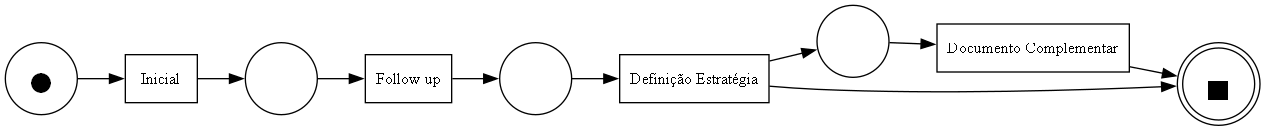

In [14]:
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer

net, initial_marking, final_marking = alpha_miner.apply(log)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

## 2. Inductive Miner
**Descrição:** O Inductive Miner é robusto e lida com ruído, gerando um Process Tree ou Petri Net. Para as solicitações, ele captura a estrutura do processo, incluindo atividades opcionais como "Documento Complementar".

**Código:**
Aplica o Inductive Miner e visualiza a Petri Net convertida.

**Resultado Esperado:**
Um modelo mais robusto que inclui "Documento Complementar" como uma atividade opcional, com transições claras entre "Inicial", "Follow up", e "Definição Estratégia".

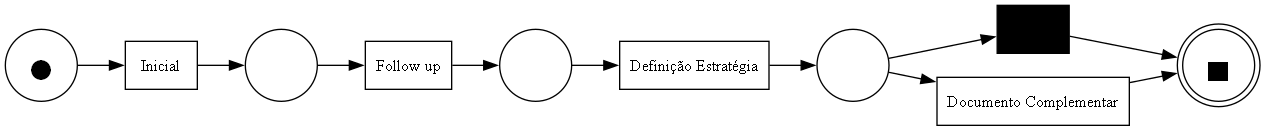

In [15]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer

process_tree = inductive_miner.apply(log)
net, initial_marking, final_marking = pm4py.convert_to_petri_net(process_tree)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

## 3. Heuristics Miner
**Descrição:** O Heuristics Miner lida com logs ruidosos, gerando um modelo baseado em frequências (Causal Net ou DFG). No caso das solicitações, ele destaca as transições mais frequentes, como "Inicial" → "Follow up".

**Código:** Aplica o Heuristics Miner e visualiza o grafo resultante.

**Resultado Esperado:** Um grafo que mostra as transições mais frequentes, com pesos indicando a força das relações (ex.: "Inicial" → "Follow up" com alta frequência).

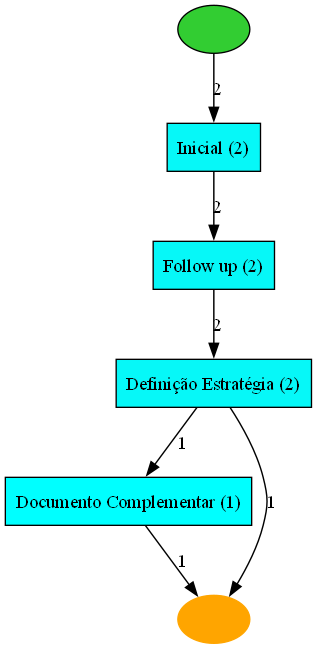

In [17]:
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# Aplicar Heuristics Miner
parameters = {heuristics_miner.Variants.CLASSIC.value.Parameters.DEPENDENCY_THRESH: 0.5}
heu_net = heuristics_miner.apply_heu(log, parameters=parameters)

# Visualizar Heuristics Net
gviz = hn_visualizer.apply(heu_net)
hn_visualizer.view(gviz)

## 4. Directly-Follows Graph (DFG)
**Descrição:** O DFG mostra a sequência direta de atividades com base na frequência. Para as solicitações, ele visualiza rapidamente como as atividades se conectam, como "Follow up" → "Definição Estratégia".

**Código:** Gera e visualiza um DFG.

**Resultado Esperado:** Um grafo simples com setas indicando a sequência de atividades e números mostrando a frequência (ex.: "Inicial" → "Follow up" ocorre 2 vezes).

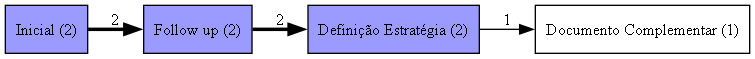

In [18]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualizer

dfg = dfg_discovery.apply(log)
gviz = dfg_visualizer.apply(dfg, log=log, variant=dfg_visualizer.Variants.FREQUENCY)
dfg_visualizer.view(gviz)

## 5. Conformance Checking
**Descrição:** Compara o log com um modelo de processo para identificar desvios. Aqui, usaremos o modelo gerado pelo Inductive Miner como referência e verificaremos se o log segue o modelo.

**Código:** Aplica o Conformance Checking usando alinhamentos.

**Resultado Esperado:** Um relatório mostrando o "fitness" de cada traço (caso) em relação ao modelo. Por exemplo, o caso com "Documento Complementar" pode ter um fitness menor se o modelo não prever essa atividade.

In [ ]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments

process_tree = inductive_miner.apply(log)
net, initial_marking, final_marking = pm4py.convert_to_petri_net(process_tree)
aligned_traces = alignments.apply(log, net, initial_marking, final_marking)
for trace in aligned_traces:
    print(f"Fitness: {trace['fitness']}")

ImportError: cannot import name 'get_log_representation' from 'pm4py.objects.log.util' (c:\Users\AJCSilva_Santana\lab\process_mining\.venv\lib\site-packages\pm4py\objects\log\util\__init__.py)

## 6. Social Network Analysis

**Descrição:** Analisa relações entre recursos (ex.: grupos ou pessoas) com base em interações. Aqui, usaremos cod_grupo como recurso para ver como os grupos colaboram nas solicitações.

**Código:** Gera uma rede social baseada em handovers (passagem de tarefas entre grupos).

**Resultado Esperado:** Um grafo mostrando conexões entre grupos (ex.: A1 → A2), com pesos indicando a frequência de handovers.

In [22]:
from pm4py.algo.organizational_mining.sna import algorithm as sna
from pm4py.visualization.sna import visualizer as sna_visualizer

sna_graph = sna.apply(log, variant=sna.Variants.HANDOVER)
gviz = sna_visualizer.apply(sna_graph, variant=sna_visualizer.Variants.PYVIS)
sna_visualizer.view(gviz)

AttributeError: HANDOVER

## 7. Transition Systems Miner

**Descrição:** Gera um modelo baseado em estados e transições, representando o processo como um autômato. Útil para entender mudanças de estado nas solicitações.

**Código:** Aplica o Transition Systems Miner e visualiza o resultado.

**Resultado Esperado:** Um autômato mostrando estados (baseados nas atividades) e transições entre eles.

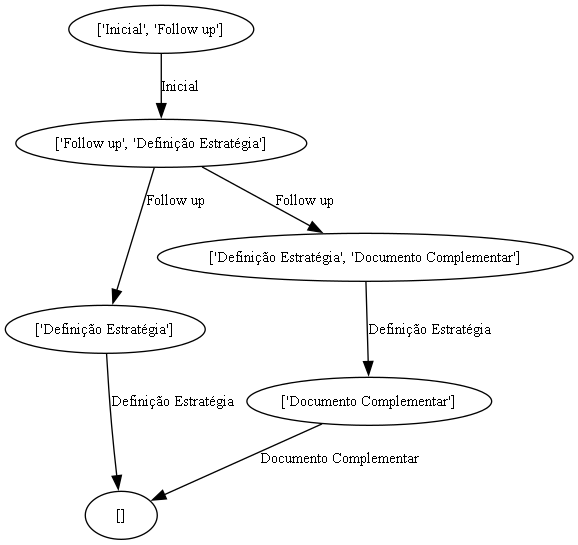

In [19]:
from pm4py.algo.discovery.transition_system import algorithm as ts_miner
from pm4py.visualization.transition_system import visualizer as ts_visualizer

ts = ts_miner.apply(log)
gviz = ts_visualizer.apply(ts)
ts_visualizer.view(gviz)

## 8. BPMN Miner
**Descrição:** Gera um modelo BPMN, que é mais legível para stakeholders. No contexto das solicitações, ele cria um diagrama padronizado do fluxo do processo.

**Código:** Converte um Process Tree (do Inductive Miner) para BPMN e visualiza.

**Resultado Esperado:** Um diagrama BPMN com atividades como "Inicial", "Follow up", e "Definição Estratégia" em um formato padrão.

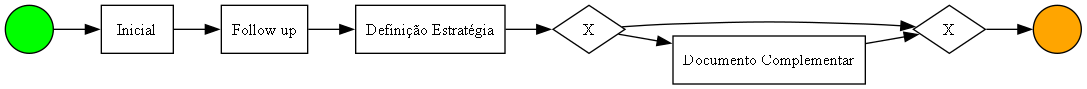

In [20]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.visualization.bpmn import visualizer as bpmn_visualizer

process_tree = inductive_miner.apply(log)
bpmn_model = pm4py.convert_to_bpmn(process_tree)
gviz = bpmn_visualizer.apply(bpmn_model)
bpmn_visualizer.view(gviz)

## 9. Performance Analysis

**Descrição:** Calcula métricas de desempenho (ex.: tempo entre atividades) e projeta no modelo. Aqui, usaremos o DFG para mostrar tempos médios entre atividades.

**Código:** Gera um DFG com métricas de desempenho.

**Resultado Esperado:** Um DFG com tempos médios entre atividades (ex.: "Follow up" → "Definição Estratégia" leva ~8 dias).

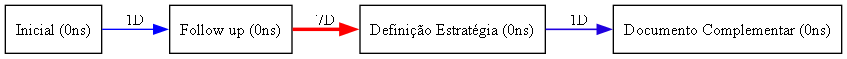

In [21]:
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery
from pm4py.visualization.dfg import visualizer as dfg_visualizer

performance_dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)
gviz = dfg_visualizer.apply(performance_dfg, log=log, variant=dfg_visualizer.Variants.PERFORMANCE)
dfg_visualizer.view(gviz)

## 10. Alignment-Based Conformance

**Descrição:** Realiza um alinhamento detalhado entre o log e um modelo, calculando custos de desvios. Similar ao Conformance Checking, mas com mais detalhes.

**Código:** Aplica o Alignment-Based Conformance.

**Resultado Esperado:** Um relatório detalhando os custos de desvios para cada traço, com alinhamentos mostrando onde o log diverge do modelo.

In [23]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments

process_tree = inductive_miner.apply(log)
net, initial_marking, final_marking = pm4py.convert_to_petri_net(process_tree)
aligned_traces = alignments.apply(log, net, initial_marking, final_marking, variant=alignments.Variants.DIJKSTRA_LESS_MEMORY)
for trace in aligned_traces:
    print(f"Cost: {trace['cost']}, Alignment: {trace['alignment']}")

AttributeError: DIJKSTRA_LESS_MEMORY

## 11. Footprint Analysis

**Descrição:** Extrai relações causais, paralelas ou conflitantes entre atividades. Útil para entender a estrutura do processo antes de modelá-lo.

**Código:** Realiza Footprint Analysis.

**Resultado Esperado:** Uma lista de relações, como "Inicial → Follow up" (causal) ou ausência de paralelismo entre atividades.

In [24]:
from pm4py.algo.discovery.footprints import algorithm as footprints_discovery

footprints = footprints_discovery.apply(log, variant=footprints_discovery.Variants.ENTIRE_EVENT_LOG)
print("Causal Relations:", footprints['causal_relations'])

KeyError: 'causal_relations'

## 12. Event Log Filtering

**Descrição:** Filtra o log para remover ruído ou casos irrelevantes. Aqui, filtraremos casos que não contêm "Definição Estratégia" para focar em processos completos.

**Código:** Aplica um filtro no log.

**Resultado Esperado:** Um log reduzido contendo apenas os casos com "Definição Estratégia", excluindo o caso com apenas "Documento Complementar".

In [25]:
from pm4py.algo.filtering.log.attributes import attributes_filter

filtered_log = attributes_filter.apply(log, ["Definição Estratégia"], parameters={"attribute_key": "concept:name"})
print(pm4py.convert_to_dataframe(filtered_log))

   id_solicitacao  id_solicitacao_origem fase_processo        negocio  \
0            1001                    NaN     Subsídios  Pessoa Física   
1            1002                 1001.0     Subsídios  Pessoa Física   
2            1004                 1001.0     Subsídios  Pessoa Física   
3            1005                    NaN     Subsídios  Pessoa Física   
4            1006                 1005.0     Subsídios  Pessoa Física   
5            1007                 1006.0     Subsídios  Pessoa Física   
6            1008                    NaN     Subsídios  Pessoa Física   

              produto            concept:name             tipo_baixa  \
0      Cartão Crédito                 Inicial             Com Follow   
1      Cartão Crédito               Follow up               Completo   
2      Cartão Crédito    Definição Estratégia   Estratégia Concluída   
3  Serviços Bancários                 Inicial             Com Follow   
4  Serviços Bancários               Follow up          